# Data Science Prep Course Capstone Review Project

# Douglas H. Wood

## Introduction

This data set consists of publicly-available files downloaded from the Citi Bike program website. The Citi Bike program began in 2013 in New York City and is now the largest bike share program in the United States. Users of the system can unlock bikes from a network of docking stations throughout the city, and return them to any other station in the system. There are now thousands of bikes and hundreds of stations in New York City and Jersey City.
The data is interesting because the use of bicycles in urban areas has the potential: to benefit the health and well-being of those who use them, to decrease the amount of engine exhaust entering city air, and to reduce the amount of money expended by residents on transportation, thereby increasing the quality of life for residents.

In this presentation, we will examine the duration of bike trips, see how the number of bikes at each station is changing as bikes are being moved around from station to station by users, and see if there is a statistical difference between round-trip and one-way use.
Insights about the changing numbers of bikes at each station will be useful to the system operator in the future as it develops or improves an algorithm that most efficiently allocates and re-distribute bikes between stations.

## Describing the Data

The first task was to decide how much of the available data to use. The Citi Bike website makes available monthly files beginning in May 2013, when the program began, through the present. Each file is between 40 and 200 MB. At a rough estimate, the average file size is 100 MB, so a year's worth of data would be around 1.2 GB. The size of all of the available data would be about 6 GB. The iMac on which I work has about 40 GB of storage in its memory, but only 4 GB of RAM, so in order to process and visualize the data in Python, I elected to try one full year of data. I selected 2016, since it is the most recent full year of data. But even with just one year of data, my computer took a long time to process some cells. Accordingly, I elected to process just two Summer months - June and July of 2016 (ridership is lower in the Winter months).

Selecting those two months was helpful in that some months had column headings with capital letters such as "Start Station ID," and other months had lower case such as "start station id." In order to facilitate processing a full year, the column headings in the data files would need to be made consistent.

The data is in .csv (Comma Separated Values) format and includes the following columns: 
Trip Duration (seconds);
Start Time and Date;
Stop Time and Date;
Start Station Name;
End Station Name;
Station ID;
Station Lat/Long;
Bike ID;
User Type (Customer = 24-hour pass or 3-day pass user, Subscriber = Annual Member);
Gender (Zero=unknown, 1=male, 2=female); and
Year of Birth.

Citi Bike processed the data to remove both trips taken by staff and any trips that were below 60 seconds in length (apparently false starts or users trying to re-dock a bike).

The next task was to assemble a master data frame out of the monthly files downloaded from the website.

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
import statistics

In [2]:
#Assemble master df ('df2016') for two months of 2016 by appending each monthly dataframe to a single dataframe.#

In [3]:
df2016 = pd.DataFrame()

In [4]:
for month in range(6,8):
    filename = '2016{}-citibike-tripdata.csv'.format(month)
    framename = pd.read_csv(filename)
    df2016 = df2016.append(framename)

One interesting initial point of discussion is the sheer size of the program, and the number of trips per year. Evidently many New York City residents find the program a useful means of transportation. There are well over thirteen million trips per year, with nearly three million trips in June and July of 2016 alone.

In [5]:
print(len(df2016))

2840428


In [6]:
print(df2016.columns)

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')


What proportion of the users are short-term customers and how many are annual members?

In [7]:
df2016.groupby('usertype').count()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,birth year,gender
usertype,,,,,,,,,,,,,,
Customer,358723,358723,358723,358723,358723,358723,358723,358723,358723,358723,358723,358723,2614,358723
Subscriber,2481705,2481705,2481705,2481705,2481705,2481705,2481705,2481705,2481705,2481705,2481705,2481705,2439013,2481705


In [8]:
358723/(358723 + 2481705)

0.12629188277259623

12.6% are short-term customers, while 87.4% are annual subscribers.

What proportion of users are male, and what proportion female? 

In [9]:
df2016.groupby('gender').count().iloc[:,0]

gender
0     404900
1    1823832
2     611696
Name: tripduration, dtype: int64

The Citi Bike website indicates that gender 0 indicates that the gender is unknown, 1 indicates male, and 2 female, so:

In [10]:
611696/(611696 + 1823832)

0.25115539628368055

25.1% of users who reported their gender reported female and 74.9% male.

How are the users distributed by age?

In [11]:
df2016['age'] = 2017 - df2016['birth year']

/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


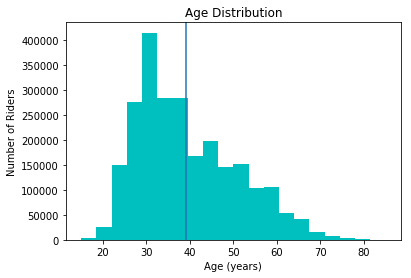

In [12]:
plt.hist(df2016['age'], bins = 20, color = 'c', range = (15,85))
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Number of Riders')
plt.axvline(df2016['age'].mean())

Another interesting initial question is how long is the average trip?

In [13]:
np.mean(df2016['tripduration'])

994.89371284890865

That's an average trip of 995 seconds, or in minutes:

In [14]:
np.mean(df2016['tripduration'])/60

16.581561880815144

The average trip is about 17 minutes, which makes intuitive sense, if most users of the system are commuting to work or running quick errands.

In [15]:
df2016['tripduration'].describe()

count    2.840428e+06
mean     9.948937e+02
std      1.101215e+04
min      6.100000e+01
25%      4.040000e+02
50%      6.740000e+02
75%      1.143000e+03
max      6.707533e+06
Name: tripduration, dtype: float64

In [16]:
longest_trip_minutes = np.max(df2016['tripduration'])/60

In [17]:
longest_trip_hours = longest_trip_minutes/60

In [18]:
longest_trip_hours/24

77.633483796296289

Somehow, a bike was taken out for 78 days, even though the average trip was only 17 minutes. The mean trip was 995 seconds, and the 75th percentile was 1143 seconds. The standard deviation, though, is 11,012 seconds. Perhaps the standard deviation may be skewed by this max outlier trip, which may have been due to a system malfunction or stolen or missing bike. Perhaps just as Citi Bike discarded very short trips from the data set, we should look at the distribution of the data to see if we should discard very long trips as well.

To see how the trip duration data is distributed, let us plot a histogram of trip duration with the range from 0 to 1150 seconds, or just above the 75th percentile.

Text(0.5,1,'Trip Duration (up to 75th Percentile)')

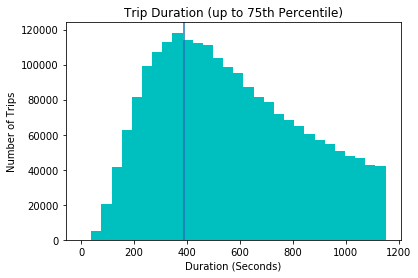

In [19]:
plt.hist(df2016['tripduration'], bins = 30, color = 'c', range = (0,1150))
plt.axvline(statistics.mode(df2016['tripduration']))
plt.xlabel('Duration (Seconds)')
plt.ylabel('Number of Trips')
plt.title('Trip Duration (up to 75th Percentile)')

## Analysis

The **first analytic question** is: What is the distribution of trip duration?

Interestingly, to the left of the mode, trip duration resembles a normal distribution, but to the right of the mode, trip duration tails off in a catenary form. The overall distribution is skewed to the left, with shorter trips increasing uniformly in frequency up to the mode, but longer trips decreasing in frequency more gradually. Does the form resemble a Poisson distribution? Let us do a QQ plot to see how well trip duration lines up with a Poisson distribution.

In [20]:
df_tripsort = pd.DataFrame()

In [21]:
df_tripsort['tripduration'] = df2016['tripduration']

In [58]:
poisson1 = np.random.poisson(100, 28404)

In [59]:
poisson1.sort()

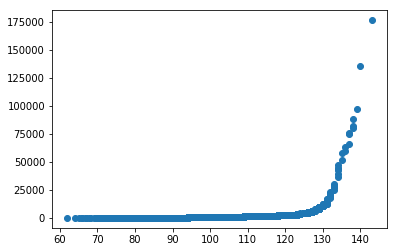

In [60]:
plt.plot(poisson1,df_tripsort.sample(frac=0.01).sort_values(by='tripduration'), "o")

Evidently trip duration is not distributed in the Poisson manner. Perhaps it is closer to a normal distribution?

In [61]:
norm = np.random.normal(400,200,28404)

In [62]:
norm.sort()

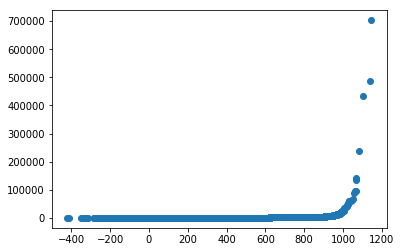

In [63]:
plt.plot(norm,df_tripsort.sample(frac=0.01).sort_values(by='tripduration'), "o")

Interestingly, trip duration is not distributed in a normal manner, either. Further analysis is required to determine which distribution most closely models trip duration.

The **second analytic question** is: Are the bikes 'migrating' to certain stations as relatively more trips end at those stations? From the perspective of the program operator, having bikes accumulate would require a system to return them from: stations at which relatively more trips end, and to: stations from which relatively more trips begin. Let us calculate how frequently each station is used as a start station and as a stop station.

In [64]:
start_count = df2016.groupby('start station id').count().iloc[:,0]

In [65]:
start_count.head()

start station id
72      7633
79      5929
82      2632
83      2895
116    12930
Name: tripduration, dtype: int64

In [66]:
stop_count = df2016.groupby('end station id').count().iloc[:,0]

In [67]:
stop_count.head()

end station id
72      7589
79      5974
82      2597
83      3266
116    13106
Name: tripduration, dtype: int64

In [68]:
df_start_stop = pd.DataFrame(start_count)
df_start_stop.columns = ['Start Count']
df_start_stop = df_start_stop.join(stop_count)
df_start_stop.columns = ['Start Count','Stop Count']

In [69]:
df_start_stop.head()

,Start Count,Stop Count
start station id,,
72,7633,7589
79,5929,5974
82,2632,2597
83,2895,3266
116,12930,13106


In [70]:
df_start_stop.sum()

Start Count    2840428
Stop Count     2840398
dtype: int64

Since the sum of the two columns is almost the same, the system is essentially "closed." Very few bikes are leaving the system - in this case, only 30 out of 2,840,428. Those bikes may require repair, or be stolen, or possibly are not logged in to an end station because they were out in use when the start and stop counts are taken.

In [71]:
df_start_stop['Deficit'] = df_start_stop['Start Count'] - df_start_stop['Stop Count']
df_start_stop['ratio'] = df_start_stop['Start Count']/df_start_stop['Stop Count']

In [72]:
df_start_stop.head()

,Start Count,Stop Count,Deficit,ratio
start station id,,,,
72,7633,7589,44,1.005798
79,5929,5974,-45,0.992467
82,2632,2597,35,1.013477
83,2895,3266,-371,0.886405
116,12930,13106,-176,0.986571


In [73]:
df_start_stop['ratio'].max()

1.9731216931216931

In [74]:
df_start_stop['ratio'].min()

0.053571428571428568

The bikes certainly are migrating. For example, the bike station with the id number 3236 is used as a starting destination twice as often as it is used as an ending destination. The system operator will have to round up bikes from other stations with lower ratios and return them there. How many bikes would the operator need to relocate in this two-month period?

In [75]:
df_start_stop['Deficit'].abs().sum()

107068

Evidently the system operator would have to move 107,068 bikes around the system in a two-month period, or roughly half a million per year, in order to keep some stations from running out of bikes and other stations from overflowing. The question of how to re-allocate the bikes within the system is much greater in magnitude than the number of bikes that leave the system (107,068 v. 30).

The **third analytic question** is: since it is possible to do both one-way trips and round trips, what proportion of the trips are round trips?

In [76]:
df_round_trip = pd.DataFrame()
df_round_trip = df2016.loc[df2016['start station id'] == df2016['end station id'], :]
len(df_round_trip)/len(df2016)

0.02225016793243835

So only 2.2% of trips were round-trip. Are these trips simply people who decide that the bikes are not to their liking, or perhaps tourists or people getting exercise?

In [77]:
df_round_trip['tripduration'].describe()

count    6.320000e+04
mean     1.836837e+03
std      8.160445e+03
min      6.100000e+01
25%      3.590000e+02
50%      1.159000e+03
75%      2.037000e+03
max      1.030505e+06
Name: tripduration, dtype: float64

Interestingly, the round trips had a mean duration of 1,836 seconds, about twice as long as the mean for one-way trips.

Is there a meaningful difference between the length of round-trips and the one-way trips, or is the difference due to random noise in the underlying data? Let us do a t-test on the two kinds of trips.

In [78]:
df_one_way = pd.DataFrame()

In [79]:
df_one_way = df2016.loc[df2016['start station id'] != df2016['end station id'],:]

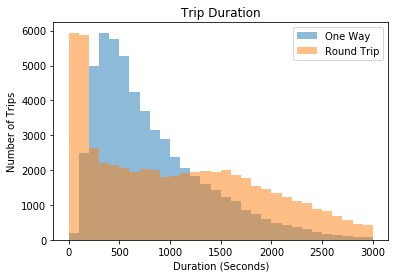

In [80]:
plt.hist(df_one_way['tripduration'].sample(frac=0.02), alpha = 0.5, bins = 30, range = (0,3000), label = 'One Way')
plt.hist(df_round_trip['tripduration'], alpha =0.5, bins = 30, range = (0,3000), label = 'Round Trip')
plt.xlabel('Duration (Seconds)')
plt.ylabel('Number of Trips')
plt.title('Trip Duration')
plt.legend(loc='upper right')

In [81]:
print(ttest_ind(df_round_trip['tripduration'], df_one_way['tripduration'], equal_var=False))

Ttest_indResult(statistic=25.989346152495486, pvalue=3.4257833278414653e-148)


The t-test is for normal distributions and these are not quite normal distributions. However, the central limit theorem shows that normal distributions can still be used to analyze samples of data from non-normally distributed populations, and here the p-value is so small that we can be confident the difference in means is due to a real difference in the populations and not due to variability in the two groups.

## Further Research

We have found that there is a net migration effect of bikes between stations in the Citi Bike program.

How could we use data to help make that process more efficient? Algorithms developed to increase efficiency in bike re-allocation would be useful across multiple industries and systems in which fleets migrate: cargo and commuter planes, truck fleets, delivery vehicle fleets, rental cars, and cargo ships, to name a few. We can use machine learning methods to predict bike arrivals at each station, and the system operator could use that information to optimize transportation of bikes.

How could we use data to help the system operator decide where to put more capacity (both bike stations and bikes)? Algorithms developed to answer this question would be useful in allocating transportation infrastructure resources. 

How could we use data to help the system operator design a better marketing campaign to attract users of all types and in various demographics, and for certain purposes (commuting, shopping, tourism, exercise)? 

Additional datasets that might help us analyze factors impacting bike usage might include temperature, weather, holidays, subway usage, subway outages, and workplace and residential population density.